# Missingness Exploration, Imputation, & Redundancy Analysis
## `R`-Based Notebook

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
%load_ext rpy2.ipython
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
#%R install.packages(c('rms', 'dplyr', 'stringr'), dependencies=T)

In [3]:
%%R
library(Hmisc); library(dplyr); library(stringr)

#### Load Data ####

# local directory
dir <- '/Volumes/AlvinSD/Bios8366_project/'

# ACCRE directory (if needed)
#dir <- '/home/jeffead1/Bios8366_project/'

df = read.csv(paste(dir, 'data/merged.csv', sep=''))

df <- select(df, -ruid, -visit_id, -admit_date, -discharge_date,
                 -readmit_time, -total_encounters, -dob, -dod)

train <- filter(df, group=='train') %>% select(-group)
valid <- filter(df, group=='valid') %>% select(-group)
test <- filter(df, group=='test') %>% select(-group)

## Patterns of Missingness

In [4]:
%%R
X_train <- select(train, -readmit_30d)
na.patterns.all <- naclus(X_train)

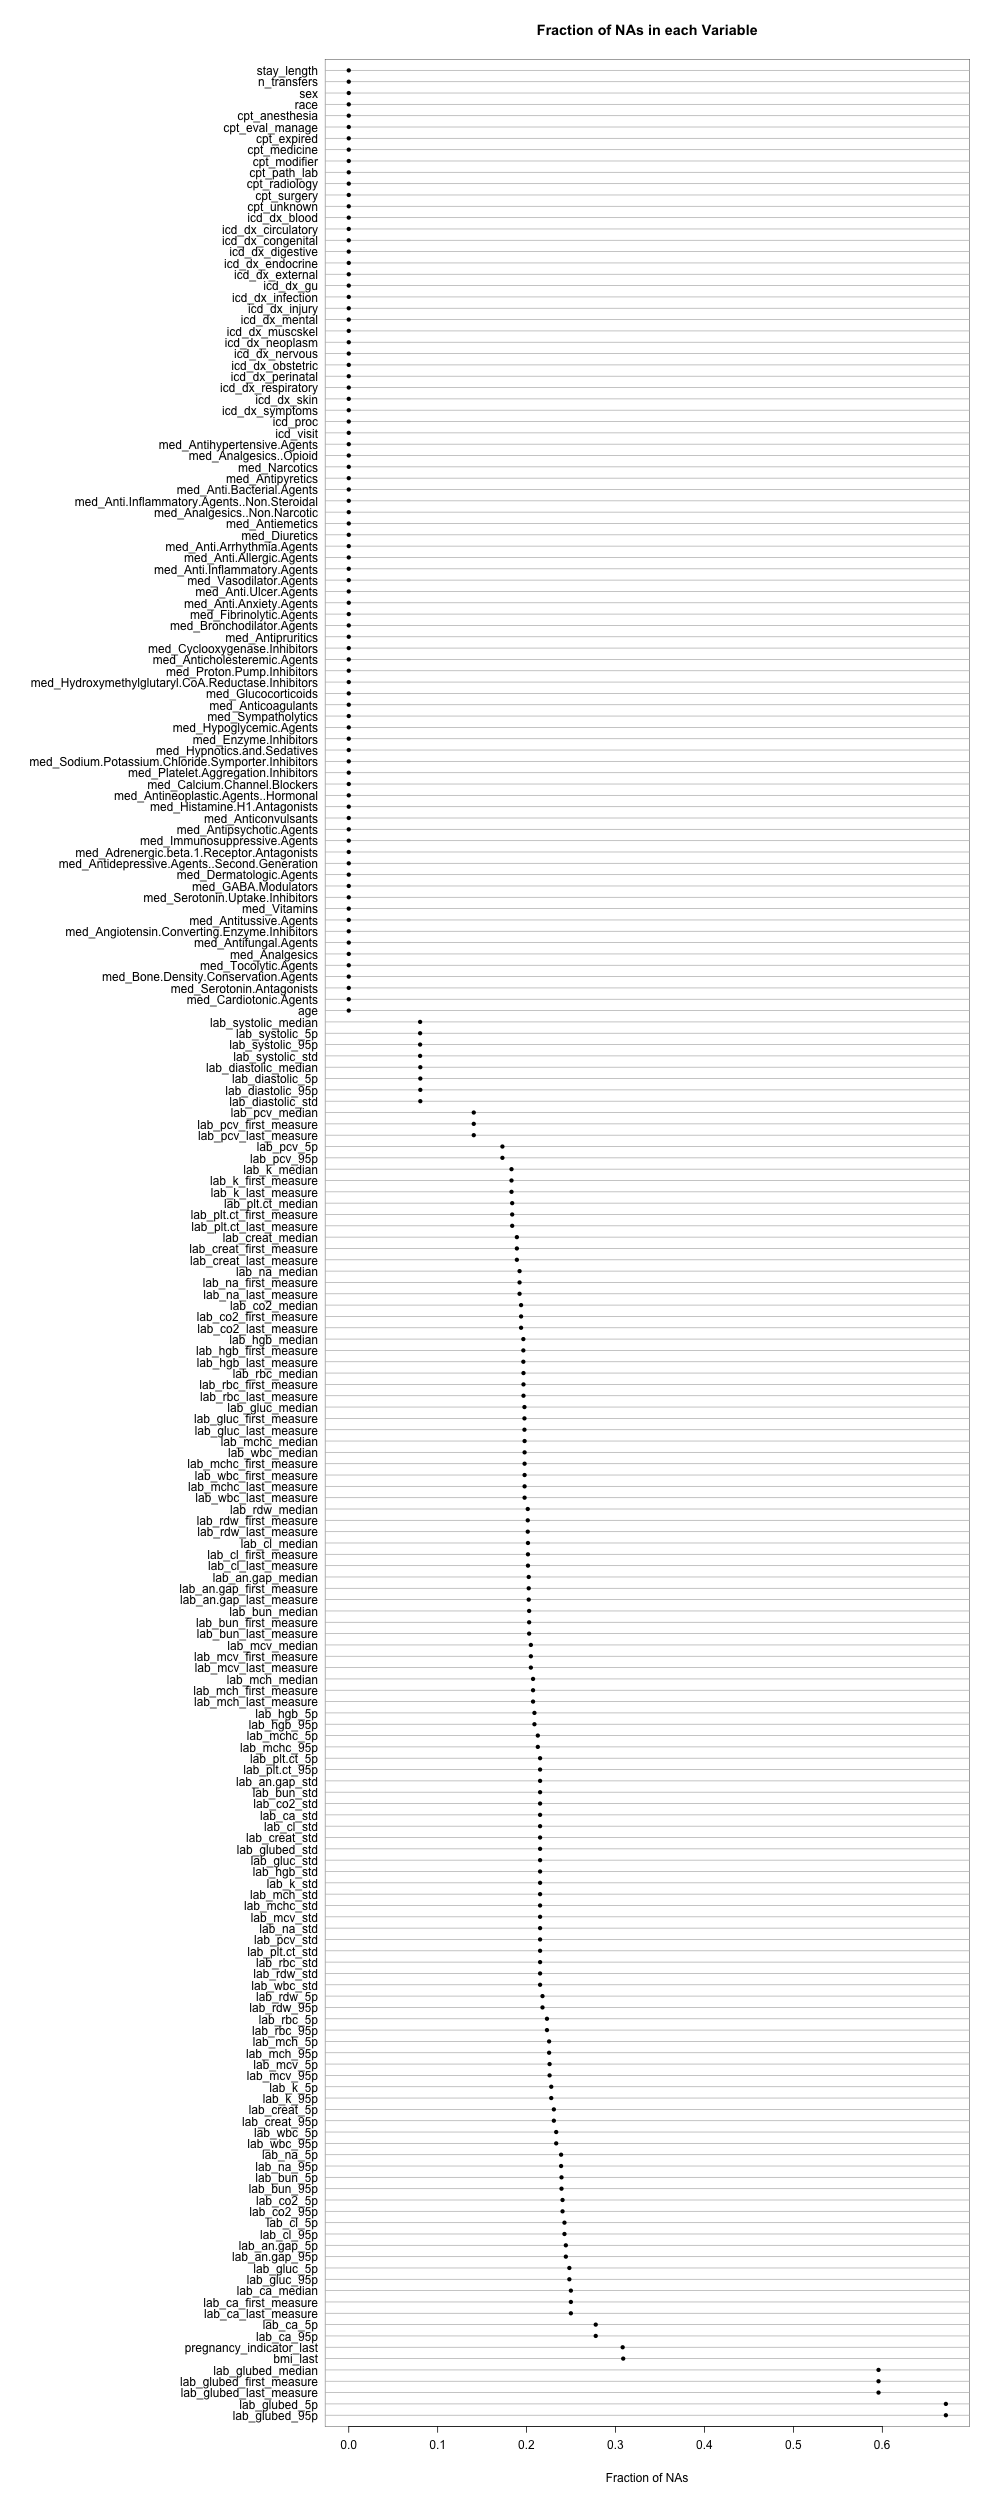

In [5]:
%%R -h 2500 -w 1000 -u px
naplot(na.patterns.all, which='na per var')

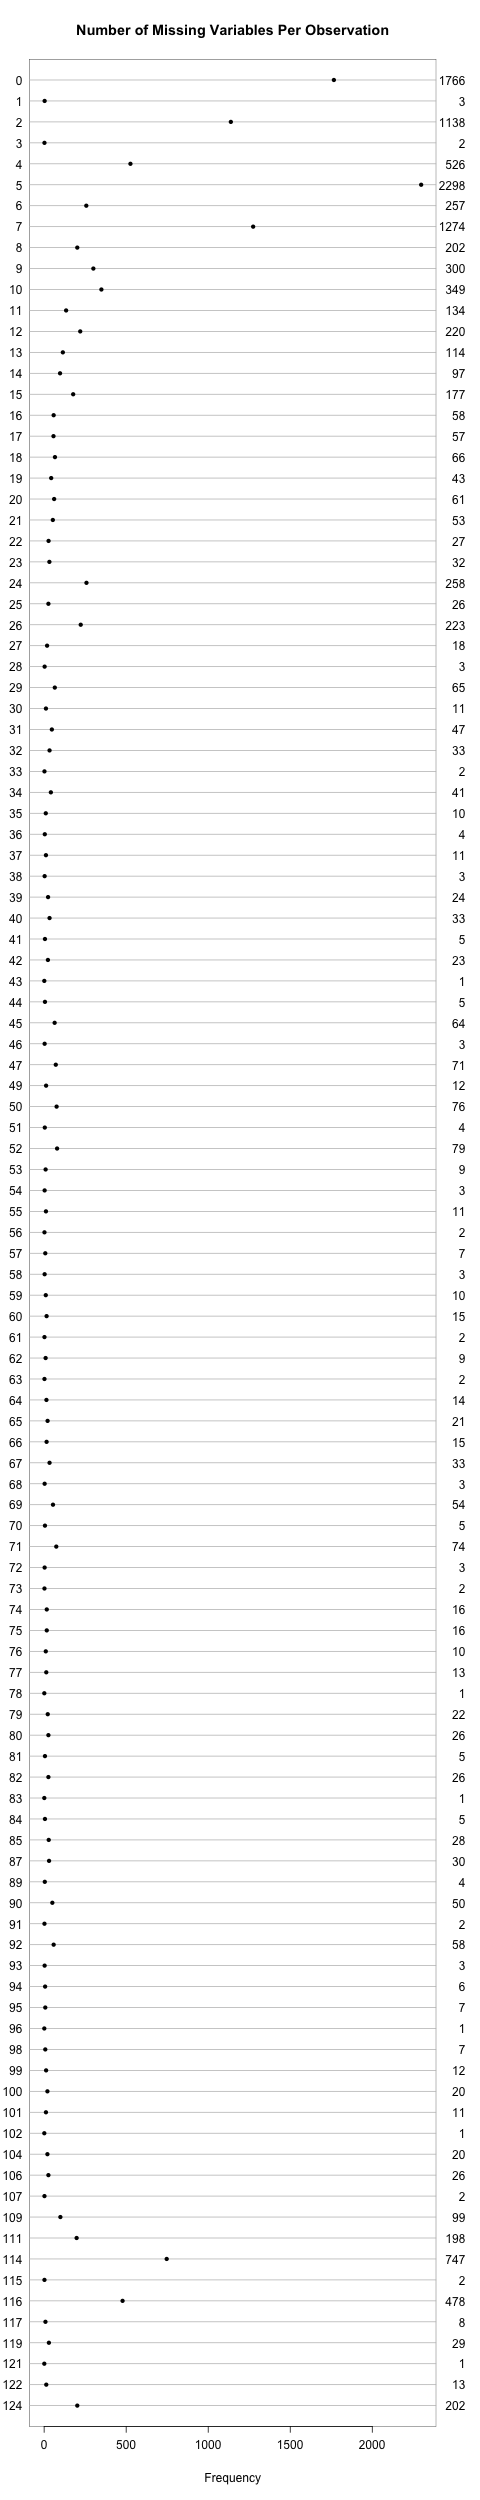

In [6]:
%%R -h 2500 -w 480 -u px
naplot(na.patterns.all, which='na per obs')

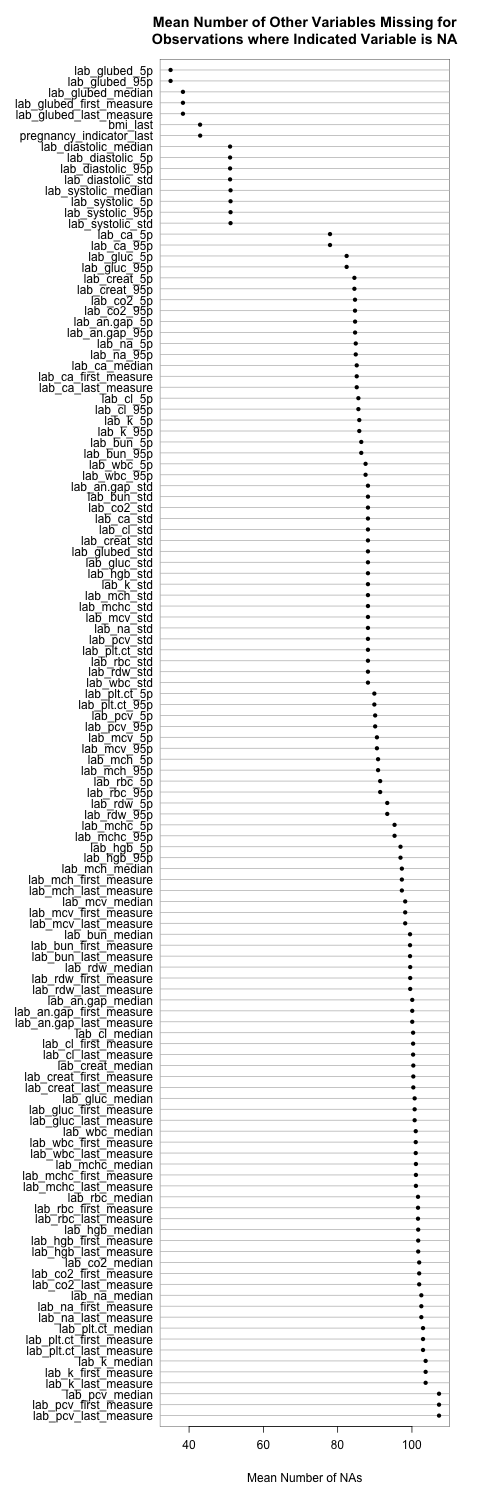

In [7]:
%%R -h 1500 -w 480 -u px
naplot(na.patterns.all, which='mean na')

## Impute

In [8]:
%%R
#### VALIDATION set ####

# ensure all variables have appropriate R structures
valid$sex <- as.factor(valid$sex)
valid$race <- as.factor(valid$race)
#valid$pregnancy_indicator <- as.factor(valid$pregnancy_indicator)
valid$readmit_30d <- as.factor(valid$readmit_30d)

# function to vectorize median imputation 
med_imp <- function(x) {
  if (is.numeric(x)) {
    x <- as.numeric(impute(x, fun=median))
  }
  else {
    x <- as.factor(x)
  }
}

valid_imp <- data.frame(lapply(valid, FUN=med_imp))

In [9]:
%%R
#### TEST set ####

# ensure all variables have appropriate R structures
test$sex <- as.factor(test$sex)
test$race <- as.factor(test$race)
#test$pregnancy_indicator <- as.factor(test$pregnancy_indicator)
test$readmit_30d <- as.factor(test$readmit_30d)

test_imp <- data.frame(lapply(test, FUN=med_imp))

In [10]:
%%R
#### TRAINING set ####

# ensure all variables have appropriate R structures
train$sex <- as.factor(train$sex)
train$race <- as.factor(train$race)
#train$pregnancy_indicator <- as.factor(train$pregnancy_indicator)

# include outcome variable in imputation
train$readmit_30d <- as.factor(train$readmit_30d)


# convert all predictors into R formula
vars <- paste(names(train), collapse=' + ')
formula <- as.formula(paste('~', vars))

---
# START: Run in R to monitor convergence
## Single Imputation with `Hmisc::transcan()`

*Note:* This step takes a while to run even with a single imputation.  It is recommended to load the existing .RData file in the subsequent step. 

```
%%R
# perform single imputation using transformed variables & canonical correlation
single_imp <- transcan(formula,
                       categorical=c('readmit_30d', 'sex', 'race'), #, 'pregnancy_indicator'),
                       
                       eps=0.2, # increase to speed up convergence (default=0.1)
                       iter.max=1000, # prevent early stopping
                       #rhsImp='random', # as opposed to 'mean' only runs 5 iterations
                       
                       # variables with fewer than 3 unique knots
                       asis=c('icd_dx_perinatal', 'icd_dx_skin'),
                       transformed=TRUE, 
                       imputed=TRUE, 
                       # if wanting multiple imputations rather than a single:
                       #n.impute=5, 
                       show.na=TRUE, 
                       pl=F, 
                       data=train)

# save transcan object due to long run-time
save(single_imp, file=paste(dir, 'data/single_imputation_training.RData', sep=''))
```

# END: Run in R
---

In [11]:
# load previously calculated transcan() object
%R load(file=paste(dir, 'data/single_imputation_training.RData', sep=''))

array(['single_imp'], dtype='<U10')

In [12]:
%%R 
# impute train data with transcan() object
train_imp <- data.frame(impute.transcan(single_imp, data=train, list.out=T))

#### Save Imputed Datasets ####
write.csv(train_imp, file=paste(dir, 'data/train_imputed.csv', sep=''))
write.csv(valid_imp, file=paste(dir, 'data/valid_imputed.csv', sep=''))
write.csv(test_imp, file=paste(dir, 'data/test_imputed.csv', sep=''))



Imputed missing values with the following frequencies
 and stored them in variables with their original names:

       lab_an.gap_median           lab_bun_median           lab_co2_median 
                    2613                     2619                     2502 
           lab_ca_median            lab_cl_median         lab_creat_median 
                    3225                     2602                     2441 
       lab_glubed_median          lab_gluc_median           lab_hgb_median 
                    7692                     2551                     2535 
            lab_k_median           lab_mch_median          lab_mchc_median 
                    2363                     2676                     2553 
          lab_mcv_median            lab_na_median           lab_pcv_median 
                    2644                     2480                     1815 
       lab_plt.ct_median           lab_rbc_median           lab_rdw_median 
                    2373                     2537 

## Redundancy Analysis

Explore correlation of variables and explore the possibility of removing redundant variables (especially for feature selection in the logistic regression). 

In [ ]:
%%R 
# make R formula
vars <- paste(names(X_train), collapse=' + ')
formula <- as.formula(paste('~', vars))

redun(formula, nk=0, data=X_train)

In [ ]:
%%R

# separate categorical & numerical features
cat_cols <- c('sex', 'race', 'pregnancy_indicator')
num_cols <- names(X_train[, !names(X_train) %in% cat_cols])

# convert all predictors into R formula
vars <- paste(num_cols, collapse=' + ')
formula <- paste('~', vars)

# attempting all variables (but singular matrix resulted)
#formula <- as.formula(paste(formula), ' + sex-1 + race-1 + pregnancy_indicator-1'))

# numerical values only
formula <- as.formula(paste(formula))

In [ ]:
%%R -h 1250 -w 1000 -u px

vc <- varclus(formula, sim='spearman', data=X_train)
plot(vc) 